# Training und Verifikation mittels MILP von Netz auf CIFAR10 Datensatz
Es sollte bereits ein trainiertes Netz existieren.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from script.Networks import *
from script.trainFunction import train_sequential
from script.Verification import verification_of_normal
import time
from jupyterthemes import jtplot

load_model = True
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)



In [10]:
transform = Compose([ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                    )

training_data = CIFAR10(root="../../cifar",
                        train=True,
                        download=True,
                        transform=transform)

test_data = CIFAR10(root="../../cifar",
                    train=False,  # test set, 10k images
                    download=True,
                    transform=transform)

batch_size = 4
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True)

classes = training_data.classes


def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

100.0%


Extracting ../../cifar\cifar-10-python.tar.gz to ../../cifar
Files already downloaded and verified


In [11]:
"""model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
"""

model = SequentialNN([32 * 32 * 3, 1024, 512, 10])

if load_model:
    model.load_state_dict(torch.load("../../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
else:
    train_sequential(model, train_dataloader, test_dataloader, epochs=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


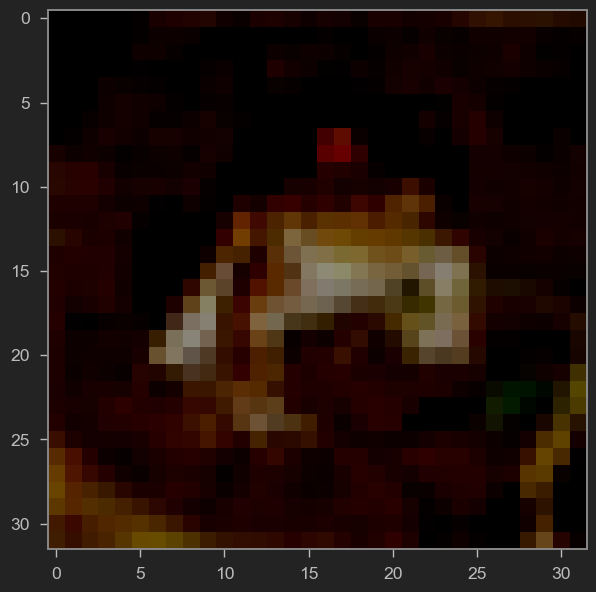

label is frog with index 6
prediction is frog with output tensor([[ 1.3665, -0.5882,  0.1332,  1.2625,  1.8794,  0.4330,  3.5173,  0.8659,
         -5.1264, -2.9051]], grad_fn=<AddmmBackward0>) 


In [12]:
images, labels = training_data.__getitem__(0)
testimage, testlabel = torch.unsqueeze(images, 0), torch.unsqueeze(torch.tensor(labels), 0)
imshow(images)
print("label is {} with index {}".format(classes[labels], labels))

pred = model(testimage)

print("prediction is {} with output {} ".format(classes[pred.argmax()], pred))




Set parameter BestObjStop to value 0.001
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13853 rows, 7710 columns and 3695161 nonzeros
Model fingerprint: 0x3eec91a5
Model has 1 general constraint
Variable types: 6174 continuous, 1536 integer (1536 binary)
Coefficient statistics:
  Matrix range     [9e-11, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [3e-05, 1e+01]
Presolve removed 7763 rows and 61 columns
Presolve time: 4.42s
Presolved: 6090 rows, 7649 columns, 3636982 nonzeros
Variable types: 6127 continuous, 1522 integer (1522 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+01   2.310873e+02   0.000000e+00      6s
    1948    1.0000000e+01   0.000000e+00   0.000000e+00      8s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.6915672700193554
-1.7074451332605838
-1.156254345283314
-0.8374928132676844
0.9797492487845068
-1.35932617942042
-0.09593489340130379
-5.76545182288155
-4.276244519178313
optimum solution with value 
 [ 3.03330905 -0.36570336  0.18548743  0.50424896  2.32149103 -0.0175844
  1.34174178  1.24580688 -4.42371005 -2.93450274]
max_var 1.6915672700193554

time to solve 21.397955417633057 s.
prediction is frog with output tensor([[ 3.0333, -0.3657,  0.1855,  0.5042,  2.3215, -0.0176,  1.3417,  1.2458,
         -4.4237, -2.9345]], grad_fn=<AddmmBackward0>) 


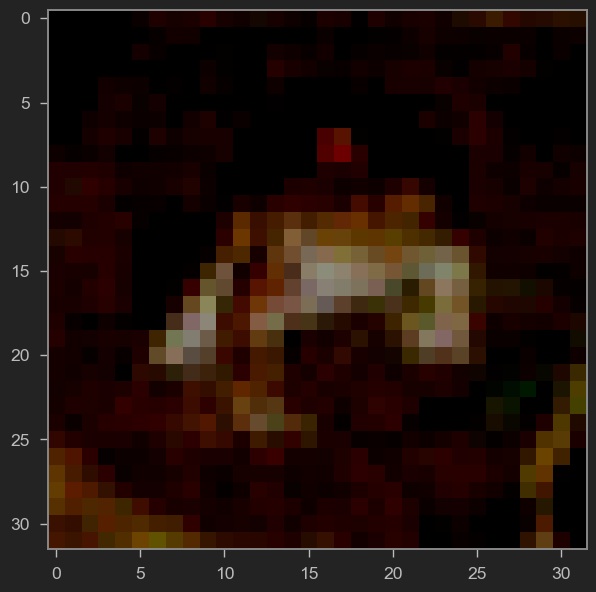

In [13]:
print("=================")
start = time.time()
alt_pic, alt_out = verification_of_normal(model, images, labels, eps=0.05, bound=0+0.001)
end = time.time() - start
print("=================")
print("")
print("time to solve {} s.".format(end))

out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[pred.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)